### Overview

This notebook does the following:

* Demonstrates how you can connect Amazon SageMaker Studio Sparkmagic kernel to a kerberized EMR cluster
* Explore and query data from a Hive table 
* Data pre-processing and feature engineering using EMR
* Trains a model using the Spark ML Lobrary
* Serializes the model to a tarball using the [MLeap](https://github.com/combust/mleap) library
* Saves some data for using on Inferece

----------

When using PySpark kernel notebooks, there is no need to create a SparkContext or a HiveContext; those are all created for you automatically when you run the first code cell, and you'll be able to see the progress printed. The contexts are created with the following variable names:
- SparkContext (sc)
- HiveContext (sqlContext)

----------
### PySpark magics 

The PySpark kernel provides some predefined “magics”, which are special commands that you can call with `%%` (e.g. `%%MAGIC` <args>). The magic command must be the first word in a code cell and allow for multiple lines of content. You can’t put comments before a cell magic.

For more information on magics, see [here](http://ipython.readthedocs.org/en/stable/interactive/magics.html).

#### Running locally (%%local)

You can use the `%%local` magic to run your code locally on the Jupyter server without going to Spark. When you use %%local all subsequent lines in the cell will be executed locally. The code in the cell must be valid Python code.

# Initial Setup

## Set the EMR Cluster ID
The code below will retrieve the cluster id and bucket name from the pre-deployed Cloudformation Stack. 

If you create the cluster in a different way, you can find this information on the [EMR console](https://console.aws.amazon.com/elasticmapreduce/home) under the "ID" field 

In [1]:
%%local
import boto3

# This will work only if there's a single created stack in the account, otherwise it will get the first one.
cfn = boto3.client('cloudformation')
stack_name = cfn.list_stacks(StackStatusFilter=['CREATE_COMPLETE'])['StackSummaries'][0]['StackName']
emr_cluster_id = cfn.describe_stack_resource(
    StackName=stack_name,
    LogicalResourceId='EMRCluster'
)['StackResourceDetail']['PhysicalResourceId']
emr_bucket = cfn.describe_stack_resource(
    StackName=stack_name,
    LogicalResourceId='S3Bucket'
)['StackResourceDetail']['PhysicalResourceId']

print(f'The EMR Cluster Id is {emr_cluster_id}\nThe S3 bucket EMR has access to is {emr_bucket}')

The EMR Cluster Id is j-YX950VXDPDGS
The S3 bucket EMR has access to is studio-emr-v5-s3bucket-t2wfrxqwzj0g


Next, we will connect to the EMR cluster as "user1" using the "sm-sparkmagic" CLI. If you dont set the user name, jobs will apear as livy user

In [ ]:
%%local
!sm-sparkmagic connect --cluster-id {emr_cluster_id} --user-name "user1"

Before running the next cell, click on the launch terminal in current SageMaker kernel image icon ($_) in the notebook toolbar above (not through the menu or Launcher) and access the terminal. In the terminal window, type `kinit user1` and when prompted for a password type in the password for "user1"

*Note: First time, use "pwd1" for the password. You will receive a message saying that your password is expired and you must change it now. Enter a new password when prompted and remember it if you have to repeat the procedure the next day.*

```
Password for user1@EC2.INTERNAL: 
Password expired.  You must change it now.

Enter new password: 
Enter it again: 
```

**Before proceeding, restart the kernel using the restart kernel icon (round arrow) from the toolbar. This is required so that SparkMagic can pickup the generated kerberos configuration**. After doing that, run the cell to retrieve cluster and bucket ids again, you'll need those variables later.

## Livy Basics
### Session information (%%info)

Livy is an open source REST server for Spark. When you execute a code cell in a sparkmagic notebook, it creates a Livy session to execute your code. `%%info` magic will display the current Livy session information.

In [2]:
%%info

You can configure the session creation parameters using the %%configure magic if needed. The example below tells spark to install the MLeap jars on demand. Run it, we'll need it to serialize the Spark models for SageMaker.

In [3]:
%%configure -f 
{
    "conf": {
        "spark.jars.packages": "ml.combust.mleap:mleap-spark_2.11:0.16.0"
    }
}

## Setup MLeap Library (do this first)

The following cell makes sure mleap.pyspark is imported before anything for PySpark integration to work (see [repo instructions](https://github.com/combust/mleap#pyspark-integration-1)).

In [4]:
import mleap.pyspark
from mleap.pyspark.spark_support import SimpleSparkSerializer

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1623093343023_0003,pyspark,idle,Link,Link,user1,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data Exploration

In the next cell, we will use the HiveContext to query Hive and look at the databases and tables

In [5]:
sqlContext = HiveContext(sqlContext) 

dbs = sqlContext.sql("show databases")
dbs.show()

tables = sqlContext.sql("show tables")
tables.show()


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+
|databaseName|
+------------+
|     default|
+------------+

+--------+-------------+-----------+
|database|    tableName|isTemporary|
+--------+-------------+-----------+
| default|movie_reviews|      false|
+--------+-------------+-----------+

Next, we will query the movie_reviews table and get the data into a spark dataframe. You can visualize the data from the remote cluster locally in the notebook 

In [6]:
movie_reviews = sqlContext.sql("select * from movie_reviews").cache()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's look at the data size and size of each class (positive and negative) and visualize it. You can see that we have a balanced dataset with equal number on both classes (25000 each)

In [7]:
# Shape
print((movie_reviews.count(), len(movie_reviews.columns)))
# count of both positive and negative sentiments
movie_reviews.groupBy('sentiment').count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(50001, 2)
DataFrame[sentiment: string, count: bigint]

In [8]:
pos_reviews = movie_reviews.filter(movie_reviews.sentiment == 'positive').collect()
neg_reviews = movie_reviews.filter(movie_reviews.sentiment == 'negative').collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

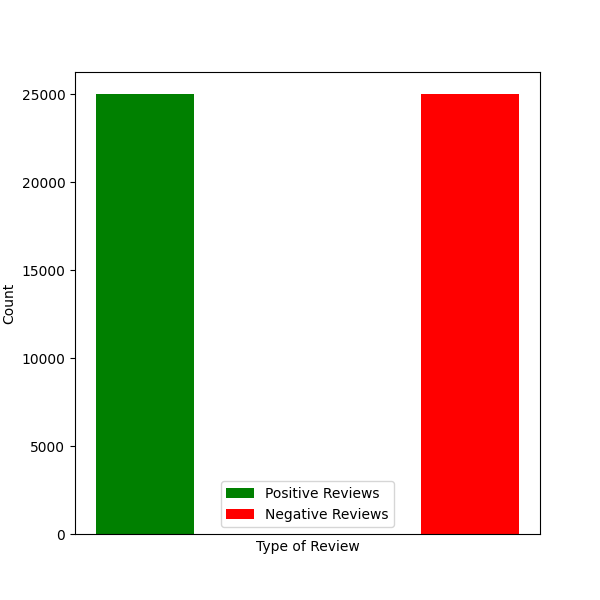

In [9]:
import matplotlib.pyplot as plt
def plot_counts(positive,negative):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,positive,width=0.6,label='Positive Reviews',color='Green')
    plt.bar(2,negative,width=0.6,label='Negative Reviews',color='Red')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.ylabel('Count')
    plt.xlabel('Type of Review')
    plt.tick_params(
        axis='x',          
        which='both',      
        bottom=False,      
        top=False,         
        labelbottom=False) 
    plt.show()
    
plot_counts(len(pos_reviews),len(neg_reviews))
%matplot plt

Next, Let's inspect length of reviews using the pyspark.sql.functions module

In [10]:
from pyspark.sql.functions import length
reviewlengthDF = movie_reviews.select(length('review').alias('Length of Review')) 
reviewlengthDF.show() 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
|Length of Review|
+----------------+
|               6|
|            1761|
|             998|
|             926|
|             748|
|            1317|
|             656|
|             726|
|             934|
|             681|
|             176|
|             578|
|             937|
|            2227|
|             662|
|             275|
|             830|
|             720|
|            1322|
|             639|
+----------------+
only showing top 20 rows

You can also execute SparkSQL queries using the %%sql magic and save results to a local data frame. This allows for quick data exploration. Max rows returned by default is 2500. You can set the max rows by using the -n argument. 

In [11]:
%%sql -o movie_reviews_sparksql_df -n 10
select * from movie_reviews 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

You can access and explore the data in the dataframe locally

In [12]:
%%local 
movie_reviews_sparksql_df.head(10)

Output()

## Training a Sentiment Classifier using Spark ML

### Data Preparation

The cell below declares functions that will format the data in preparation for training the model:

- `remove_betwee_square_brackets`: cleans text between brackets, as it is not relevant for sentiment
- `denoise_text`: general noise remover. Currently only removes text between brackets
- `preprocess_text`: denoises, replaces all whitespace with single space, removes single characters
- `process_data`: applies the transformation to the `review` and `sentiment` columns

In [13]:
import re
from pyspark.sql.functions import *
from pyspark.sql.types import *


labels_dict = {'positive': 1,
               'negative': 0
              }

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def denoise_text(text):
    text = remove_between_square_brackets(text)
    return text

def preprocess_text(document):
    document = denoise_text(document)
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(document))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    return document

preprocess_text_udf = udf(preprocess_text, StringType())

def process_data(df, review_column: str="review", sentiment_column: str="sentiment"):
    review_2 = review_column + "2"
    sentiment_2 = sentiment_column + "2"
    return df.withColumn(
        review_2, preprocess_text_udf(col(review_column))
    ).drop(review_column).withColumnRenamed(
        review_2, review_column
    ).withColumn(
        sentiment_2, when(df.sentiment=="positive", 1).otherwise(0)
    ).drop(sentiment_column).withColumnRenamed(
        sentiment_2, "label"
    )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

def create_pipeline(model, text_col: str="review", label_col: str="sentiment", num_features: int=2**16, min_doc_freq: int=5):
    """
    Creates a pipeline to:
        - tokenize, hash by TF, calculate IDF on the text column
        - Index the label column strings
    Returns the pipeline 
    """
    tokenizer = Tokenizer(inputCol=text_col, outputCol="words")
    hashtf = HashingTF(numFeatures=num_features, inputCol="words", outputCol='tf')
    idf = IDF(inputCol='tf', outputCol="features", minDocFreq=min_doc_freq) #minDocFreq: remove sparse terms
    #label_stringIdx = StringIndexer(inputCol=label_col, outputCol="label")
    pipeline = Pipeline(stages=[tokenizer, hashtf, idf, model])
    return pipeline

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
def prepare_data(df, train_pct: float=0.7, verbose: bool = True):
    """
    Splits the df dataset into train and test, creates the pipeline, processes the data through the pipeline and returns the resulting pipeline and datasets
    """
    train_data, validation_data = df.randomSplit([train_pct, 1.0 - train_pct])
    train_data = process_data(train_data).cache()
    validation_data = process_data(validation_data)
    if verbose:
        print("train_data=============================")
        print(train_data.head())

        print("validation_data========================")
        print(validation_data.head())
    return train_data, validation_data
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def create_model(max_iter: int=100):
    """
    Trains a logistic regression model on the dataset passed to it
    """
    lr = LogisticRegression(maxIter=max_iter)
    return lr

def evaluate_predictions(predictions, raw_prediction_col: str="rawPrediction", metric_name: str='areaUnderROC'):
    """
    Calculates an evaluation metric (default AUC) on the specified column of the predictions
    """
    evaluator = BinaryClassificationEvaluator(rawPredictionCol=raw_prediction_col, metricName=metric_name)
    return evaluator.evaluate(predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The cell below will send the `emr_bucket` variable we retrieved from the cloudformation to the Spark cluster.

_note_: If it fails with "Variable named emr_bucket not found", you may need to re-execute the first code cell in this notebook, to retrieve the values again. It got erased when we reinitialized the kernel to connect to the EMR cluster.

In [17]:
%%send_to_spark -i emr_bucket -t str -n emr_bucket

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'emr_bucket' as 'emr_bucket' to Spark kernel

This code takes the full transformation and inference pipeline and serializes it to MLeap format. The dataframe passed to it is used to infer the proper schema.

In [18]:
#from mleap.pyspark.spark_support import SimpleSparkSerializer
import zipfile
import tarfile
import boto3
import os

def serialize(pipeline, df, tmp_path: str='/tmp', bucket: str=emr_bucket, key: str="emr/movie_reviews/mleap"):
    """
    Serializes a data preparation pipeline and a model to an MLeap bundle, saves it to an S3 path and returns said path.
    """
    SimpleSparkSerializer().serializeToBundle(
        pipeline, f"jar:file:{tmp_path}/model.zip", df
    )
    with zipfile.ZipFile(f"{tmp_path}/model.zip") as zf:
        zf.extractall(f"{tmp_path}/model")
    with tarfile.open(f"{tmp_path}/model.tar.gz", "w:gz") as tar:
        tar.add(f"{tmp_path}/model/bundle.json", arcname="bundle.json")
        tar.add(f"{tmp_path}/model/root", arcname="root")
    s3 = boto3.resource("s3")
    file_name = os.path.join(key, "model.tar.gz")
    s3.Bucket(bucket).upload_file(f"{tmp_path}/model.tar.gz", file_name)
    return f"s3://{bucket}/{file_name}"

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we finally execute the entire logic:
- Retrieve the data
- Train/test split and data cleansing
- Model definition
- Pipeline creation
- Training the pipeline
- Generating inference
- Evaluating results

In [19]:
if __name__ in {"__main__", "builtins"}:
    movie_reviews = sqlContext.sql("select * from movie_reviews")
    train_df, val_df = prepare_data(movie_reviews, verbose=False)
    train_df.show(5)
    model = create_model()
    pipeline = create_pipeline(model)
    fitModel = pipeline.fit(train_df)
    predictions = fitModel.transform(val_df)
    evaluation = evaluate_predictions(predictions)
    print(f"AUC Metric: {evaluation:0.4f}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|              review|label|
+--------------------+-----+
| Så som himmelen ...|    1|
| Thief in the Nig...|    1|
| bored television...|    0|
| death at college...|    0|
| lot of the films...|    0|
+--------------------+-----+
only showing top 5 rows

AUC Metric: 0.9261

And here's the schema of the predictions dataframe. We'll use it again for testing inference, so let's save a copy of it.

In [20]:
predictions.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- review: string (nullable = true)
 |-- label: integer (nullable = false)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- tf: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)

In [25]:
predictions.select(
    "review", "label", "prediction"
).repartition(1).write.format("csv").option("header", "true").mode("overwrite").save(
    f"s3://{emr_bucket}/emr/movie_reviews/output/predictions.csv"
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

And we'll also save the serialized pipeline. Notice that MLeap can only serialize objects of the `PipelineModel` class, so always wrap your model in a pipeline even if there are no other steps.

In [24]:
if __name__ in {"__main__", "builtins"}:
    s3_uri = serialize(fitModel, predictions.drop("label"))    
    print(f"Serialized model saved to {s3_uri}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Serialized model saved to s3://studio-emr-v5-s3bucket-t2wfrxqwzj0g/emr/movie_reviews/mleap/model.tar.gz

That concludes the training example. Please proceed to the "SageMaker PySpark EMR Serving" notebook to see how to deploy the model.